# Sales

## Notebook set-up

In [2]:
import os
import pickle

import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import helper_functions as funcs

label = 'Turnaround_Time'

## 1. Asset loading

### 1.1. Data

In [3]:
with open('../data/processed/turnaround_time.pkl', 'rb') as input_file:
    turnaround_data = pickle.load(input_file)

train_df = turnaround_data['training']
test_df = turnaround_data['testing']

In [4]:
train_df.head()

,Ship_Mode,Segment,City,State,Sub_Category,Order_Year,Order_Month,Order_Day,Turnaround_Time
2434,First Class,Corporate,Springfield,Virginia,Envelopes,2016,11,0,3
9746,Same Day,Consumer,Los Angeles,California,Tables,2018,11,5,0
2289,First Class,Corporate,Seattle,Washington,Tables,2018,1,0,3
7070,Second Class,Home Office,Chicago,Illinois,Paper,2017,9,1,5
7989,Standard Class,Home Office,Sheboygan,Wisconsin,Storage,2017,8,2,6


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6536 entries, 2434 to 4359
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ship_Mode        6536 non-null   object
 1   Segment          6536 non-null   object
 2   City             6536 non-null   object
 3   State            6536 non-null   object
 4   Sub_Category     6536 non-null   object
 5   Order_Year       6536 non-null   int32 
 6   Order_Month      6536 non-null   int32 
 7   Order_Day        6536 non-null   int32 
 8   Turnaround_Time  6536 non-null   int64 
dtypes: int32(3), int64(1), object(5)
memory usage: 434.0+ KB


## 2. Data preparation

### 2.1. One-hot encoding

In [6]:
features = ['Segment', 'City', 'State', 'Sub_Category', 'Ship_Mode']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist')

encoded_training_features = onehot_encoder.fit_transform(train_df[features])
encoded_testing_features = onehot_encoder.transform(test_df[features])

encoded_training_df = pd.DataFrame(
    encoded_training_features,
    columns=onehot_encoder.get_feature_names_out()
)

encoded_testing_df = pd.DataFrame(
    encoded_testing_features,
    columns=onehot_encoder.get_feature_names_out()
)

train_df.drop(columns=features, inplace=True)
test_df.drop(columns=features, inplace=True)

train_df = pd.concat([encoded_training_df.reset_index(drop=True), train_df.reset_index(drop=True)], axis=1)
test_df = pd.concat([encoded_testing_df.reset_index(drop=True), test_df.reset_index(drop=True)], axis=1)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6536 entries, 0 to 6535
Columns: 570 entries, Segment_Consumer to Turnaround_Time
dtypes: float64(566), int32(3), int64(1)
memory usage: 28.3 MB


### 2.2. Time encoding

In [7]:
month_sin_transformer = funcs.sin_transform(period=12)
month_cos_transformer = funcs.cos_transform(period=12)

train_df['Order_Month_Sin'] = month_sin_transformer.fit_transform(train_df['Order_Month'])
test_df['Order_Month_Sin'] = month_sin_transformer.transform(test_df['Order_Month'])

train_df['Order_Month_Cos'] = month_cos_transformer.fit_transform(train_df['Order_Month'])
test_df['Order_Month_Cos'] = month_cos_transformer.transform(test_df['Order_Month'])


In [8]:
day_sin_transformer = funcs.sin_transform(period=7)
day_cos_transformer = funcs.cos_transform(period=7)

train_df['Order_Day_Sin'] = day_sin_transformer.fit_transform(train_df['Order_Day'])
test_df['Order_Day_Sin'] = month_sin_transformer.transform(test_df['Order_Day'])

train_df['Order_Day_Cos'] = day_cos_transformer.fit_transform(train_df['Order_Day'])
test_df['Order_Day_Cos'] = day_cos_transformer.transform(test_df['Order_Day'])

In [9]:
train_df.drop(['Order_Month', 'Order_Day'], axis=1, inplace=True)
test_df.drop(['Order_Month', 'Order_Day'], axis=1, inplace=True)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6536 entries, 0 to 6535
Columns: 572 entries, Segment_Consumer to Order_Day_Cos
dtypes: float64(570), int32(1), int64(1)
memory usage: 28.5 MB


### 2.3. Standard scaling

In [10]:
features = train_df.columns.to_list()
features.remove('Turnaround_Time')

scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

## 3. Logistic regression

Training Accuracy = 54.3
Testing Accuracy = 41.1



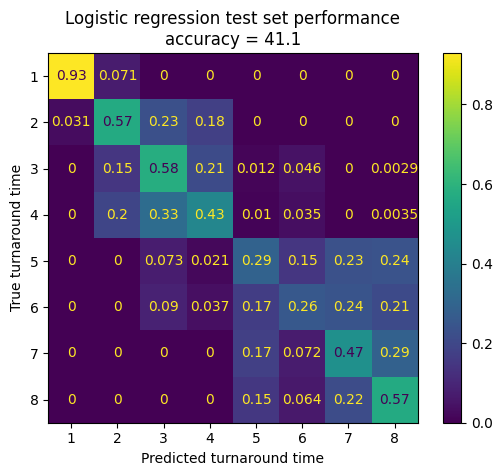

In [11]:
linear_model = funcs.train_evaluate_classification(
    model=LogisticRegression(class_weight='balanced', max_iter=1000),
    train_df=train_df,
    test_df=test_df,
    label=label,
    plot_title='Logistic regression test set performance',
)

## 5. Gradient boosting

Training Accuracy = 86.1
Testing Accuracy = 54.9



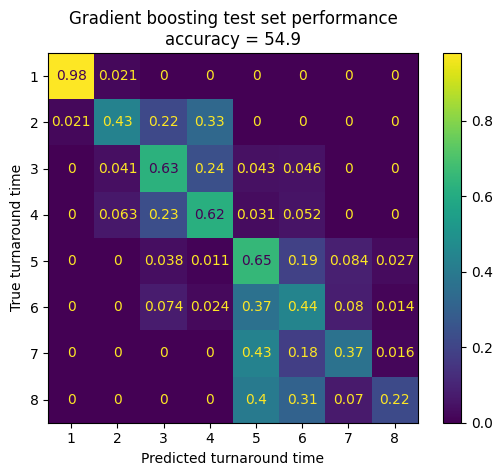

In [12]:
gbt_model = funcs.train_evaluate_classification(
    model=HistGradientBoostingClassifier(),
    train_df=train_df,
    test_df=test_df,
    label=label,
    plot_title='Gradient boosting test set performance'
)

## 6. PCA + Gradient boosting

In [13]:
# Samples
N_ITER = 500

# Cross validation strategy
CV_FOLDS = 10
CV_SPLIT = 0.5

# CPU utilization
N_JOBS = 10

CROSS_VAL = ShuffleSplit(
    n_splits=CV_FOLDS,
    test_size=CV_SPLIT,
    random_state=315
)

In [14]:
# Initialize pipeline components
pca = PCA()
regressor = HistGradientBoostingClassifier()

pipeline = Pipeline(steps=[('PCA', pca), ('classifier', regressor)])

# Define hyperparameter search space for gradient boosting optimization
hyperparameters = {
    'PCA__n_components': list(range(1, len(train_df.columns))),
    'classifier__learning_rate': loguniform(10**-5, 1.0),
    'classifier__max_iter': randint(2, 200),
    'classifier__max_leaf_nodes':randint(2, 1000),
    'classifier__max_depth':randint(1, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__l2_regularization': loguniform(10**-5, 1.0),
    'classifier__max_features':uniform(loc=0.1, scale=0.9),
    'classifier__max_bins': randint(10, 255),
    'classifier__interaction_cst': ['pairwise', 'no_interactions'],
}

# Perform randomized search over hyperparameters
search = RandomizedSearchCV(
    pipeline,
    hyperparameters,
    return_train_score=True, # Return training scores for analysis
    cv=CROSS_VAL,            # Use stratified shuffle split for cross-validation
    n_jobs=N_JOBS,           # Set CPU core count
    n_iter=N_ITER,           # Number of parameter combinations to try
    random_state=315         # Ensure reproducible results
)

# Fit the search and extract best model and parameters
search_results = search.fit(train_df.drop(label, axis=1), train_df[label])
best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

# Display the best hyperparameters found
print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()

if N_JOBS == -1:
    print(f'Run time ({os.cpu_count()} CPUs):\n')

else:
    print(print(f'Run time ({N_JOBS} CPUs):\n'))

Best hyperparameters:

 PCA__n_components: 467
 classifier__interaction_cst: pairwise
 classifier__l2_regularization: 0.24170820941347035
 classifier__learning_rate: 0.1120613878944749
 classifier__max_bins: 220
 classifier__max_depth: 10
 classifier__max_features: 0.18823685834020024
 classifier__max_iter: 182
 classifier__max_leaf_nodes: 590
 classifier__min_samples_leaf: 8

Run time (10 CPUs):

None


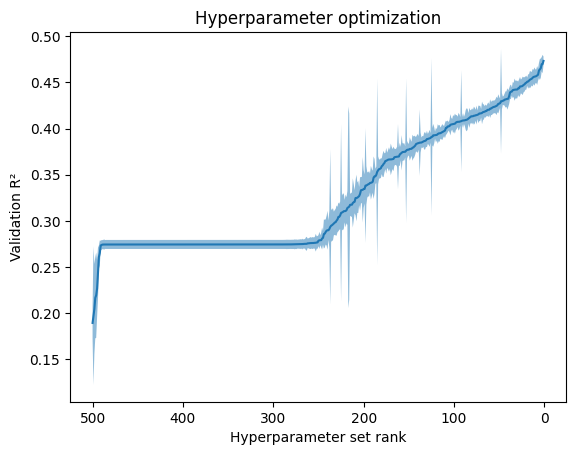

In [15]:
funcs.plot_cross_validation(search_results)

Training Accuracy = 99.7
Testing Accuracy = 53.7



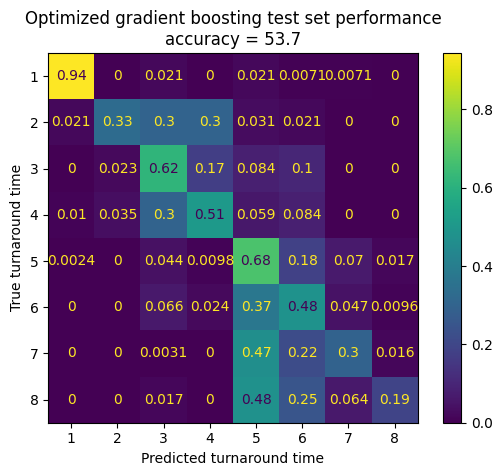

In [16]:
best_gbt_model = funcs.train_evaluate_classification(
    model=best_model,
    train_df=train_df,
    test_df=test_df,
    label=label,
    plot_title='Optimized gradient boosting test set performance'
)

## 7. Save

In [17]:
time_transformers = {
    'month_sin': month_sin_transformer,
    'month_cos': month_cos_transformer
}

with open('../models/turnaround_time_transformers.pkl', 'wb') as output_file:
    pickle.dump(time_transformers, output_file)

with open('../models/turnaround_onehot_encoder.pkl', 'wb') as output_file:
    pickle.dump(onehot_encoder, output_file)

with open('../models/turnaround_standard_scaler.pkl', 'wb') as output_file:
    pickle.dump(scaler, output_file)

with open('../models/turnaround_gbt.pkl', 'wb') as output_file:
    pickle.dump(best_model, output_file)